In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
train_ds_cd, test_ds_cd = tf.keras.utils.image_dataset_from_directory(
    "../data/classes1", # путь к изображениям
    validation_split=0.2, # процент на тест
    subset="both", # берем и обучающую и тестовую выборку
    seed=42, # сид генератора случайных чисел
    image_size=(200,400), # целевой размер изображения (СНАЧАЛА ВЫСОТА, ПОТОМ ШИРИНА)
    batch_size=25, # размер пакета (батча)
)


Found 2000 files belonging to 2 classes.
Using 1600 files for training.
Using 400 files for validation.


In [3]:
data_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.RandomFlip("horizontal_and_vertical"),
        tf.keras.layers.RandomRotation(0.1),
    ]
)

In [4]:
train_ds_cd = train_ds_cd.map(
    lambda img, label: (data_augmentation(img), label)
)

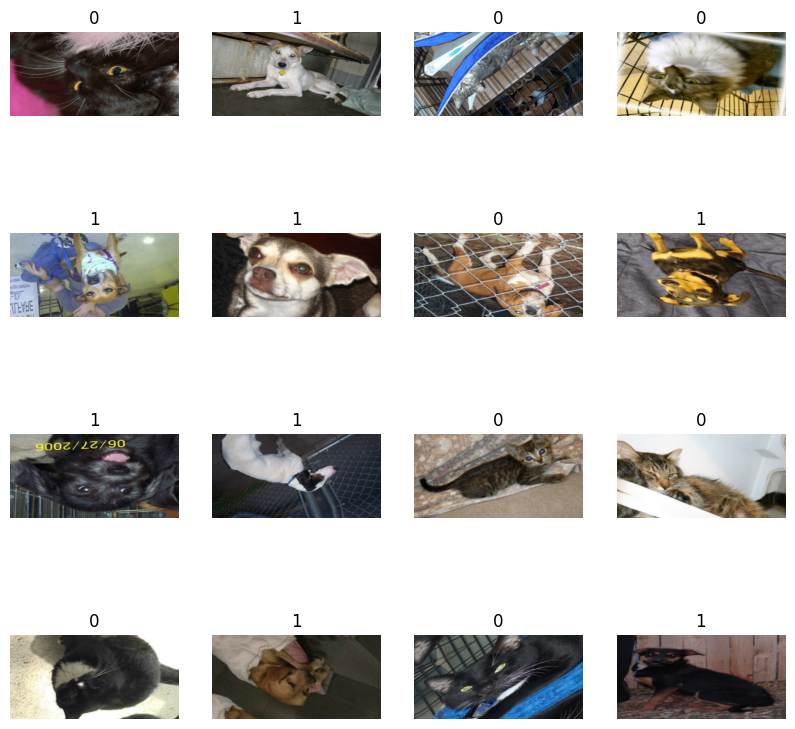

In [5]:
plt.figure(figsize=(10, 10))
# берем один батч
for images, labels in train_ds_cd.take(1):
    # отрисуем 16 картинок из батча
    for i in range(16):
        ax = plt.subplot(4, 4, i + 1)
        # выводим картинку
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        # выключаем оси (чтобы они не отображались)
        plt.axis("off")

In [6]:
# входной слой - размер (200, 400, 3)
inputs = tf.keras.Input(shape=(200, 400, 3))
# преобразуем значения пикселей из [0, 255] к [0, 1]
x = tf.keras.layers.Rescaling(1.0 / 255)(inputs)
x = tf.keras.layers.Conv2D(64, 3, strides=2, padding="same")(x)
x = tf.keras.layers.MaxPooling2D(3, strides=2, padding="same")(x)
x = tf.keras.layers.Conv2D(128, 4, strides=2, padding="same")(x)
x = tf.keras.layers.MaxPooling2D(3, strides=2, padding="same")(x)
x = tf.keras.layers.Conv2D(64, 4, strides=2, padding="same")(x)
x = tf.keras.layers.MaxPooling2D(3, strides=2, padding="same")(x)
# выпрямляем многомерный массив
x = tf.keras.layers.Flatten()(x)
# полносвязный слой с 64 нейронами
x = tf.keras.layers.Dense(64, activation="relu")(x)
# выходной слой с функцией sofrmax
outputs = tf.keras.layers.Dense(2, activation="softmax")(x)
model = tf.keras.Model(inputs, outputs)

In [7]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200, 400, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 200, 400, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 100, 200, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2  (None, 50, 100, 64)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 25, 50, 128)       131200    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 13, 25, 128)       0         
 g2D)                                                        

In [8]:
model.compile(optimizer=tf.keras.optimizers.Adam(1e-3), loss="sparse_categorical_crossentropy", metrics=["accuracy"])

In [9]:
model.fit(train_ds_cd, epochs=20, validation_data=test_ds_cd)

Epoch 1/20


64/64 [==============================] - 14s 204ms/step - loss: 0.7046 - accuracy: 0.5412 - val_loss: 0.6241 - val_accuracy: 0.6175
Epoch 2/20
64/64 [==============================] - 13s 202ms/step - loss: 0.6739 - accuracy: 0.5875 - val_loss: 0.6676 - val_accuracy: 0.5600
Epoch 3/20
64/64 [==============================] - 13s 203ms/step - loss: 0.6374 - accuracy: 0.6256 - val_loss: 0.6455 - val_accuracy: 0.6125
Epoch 4/20
64/64 [==============================] - 13s 200ms/step - loss: 0.6598 - accuracy: 0.6087 - val_loss: 0.6455 - val_accuracy: 0.5925
Epoch 5/20
64/64 [==============================] - 13s 202ms/step - loss: 0.6365 - accuracy: 0.6319 - val_loss: 0.6138 - val_accuracy: 0.6300
Epoch 6/20
64/64 [==============================] - 13s 198ms/step - loss: 0.5951 - accuracy: 0.6837 - val_loss: 0.5719 - val_accuracy: 0.6725
Epoch 7/20
64/64 [==============================] - 13s 199ms/step - loss: 0.6223 - accuracy: 0.6662 - val_loss: 0.5949 - val_accuracy: 0.68

In [10]:
predictions = [np.argmax(pred) for pred in model.predict(test_ds_cd)]

16/16 [==============================] - 1s 42ms/step


In [11]:
y_test = np.empty(400)
j=0;
for images, labels in test_ds_cd.take(16):
    for i in range(25):
        y_test[j+i] = int(labels[i])
    j+=25
print(j)

400


In [12]:
print(classification_report(y_test, predictions))
print(confusion_matrix(y_test, predictions))

              precision    recall  f1-score   support

         0.0       0.77      0.61      0.68       182
         1.0       0.72      0.84      0.78       218

    accuracy                           0.74       400
   macro avg       0.74      0.73      0.73       400
weighted avg       0.74      0.74      0.73       400

[[111  71]
 [ 34 184]]


# Задание 2

## VGG19

In [13]:
# формируем датасет
train_ds, test_ds = tf.keras.utils.image_dataset_from_directory(
    "../data/classes", # путь к изображениям
    validation_split=0.15, # процент на тест
    subset="both", # берем и обучающую и тестовую выборку
    seed=42, # сид генератора случайных чисел
    image_size=(224,224), # целевой размер изображения (СНАЧАЛА ВЫСОТА, ПОТОМ ШИРИНА)
    batch_size=25, # размер пакета (батча)
)

Found 1086 files belonging to 3 classes.
Using 924 files for training.
Using 162 files for validation.


In [14]:
data_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomContrast([1.0, 5.0])
    ]
)

In [15]:
train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img), label)
)

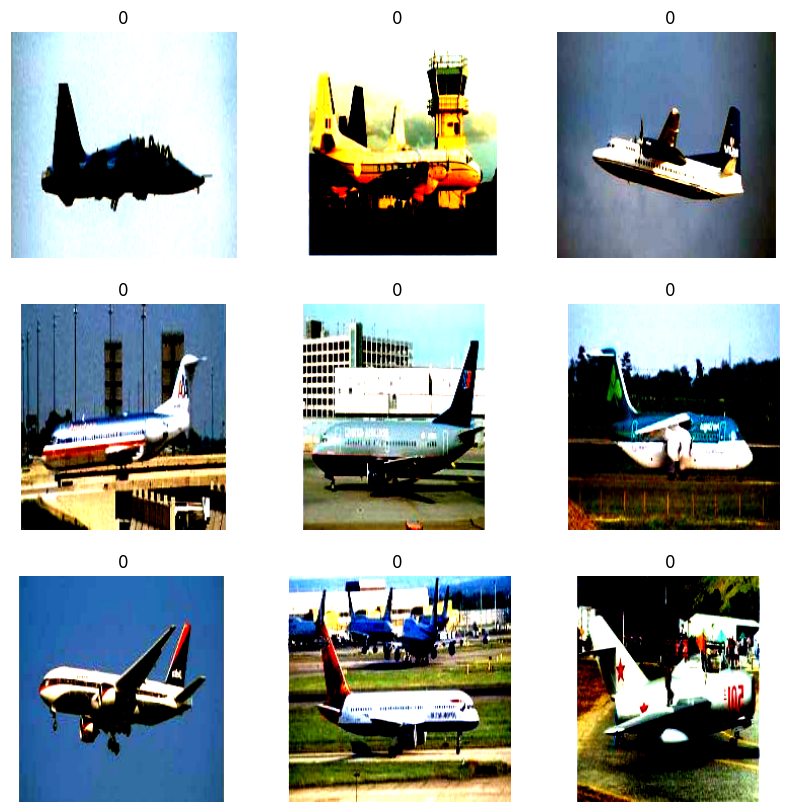

In [16]:
plt.figure(figsize=(10, 10))
# берем один батч
for images, labels in train_ds.take(1):
    # отрисуем 9 картинок из батча
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        # выводим картинку
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        # выключаем оси (чтобы они не отображались)
        plt.axis("off")

In [18]:
vgg = tf.keras.applications.VGG19(weights='imagenet', include_top=True)
vgg.summary()

574710816/574710816 [==============================] - 5037s 9us/step
Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                         

In [19]:
# сохраним ссылку на входной слой сети
inp = vgg.input

# создадим новый слой классификации по нашему количеству классов
new_classification_layer = tf.keras.layers.Dense(3, activation='softmax')

# соединим предпоследний слой VGG и наш новый слой классификации
out = new_classification_layer(vgg.layers[-2].output)

# создадим новую модель
model_new = tf.keras.Model(inp, out)

In [20]:
model_new.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [21]:
for layer in model_new.layers:
    layer.trainable = False
model_new.layers[-1].trainable = True
model_new.layers[-2].trainable = True

In [22]:
model_new.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_new.summary()


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0  

In [23]:
model_new.fit(train_ds, epochs=5, validation_data=test_ds)

Epoch 1/5
37/37 [==============================] - 63s 2s/step - loss: 1.3752 - accuracy: 0.9621 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 2/5
37/37 [==============================] - 64s 2s/step - loss: 0.0471 - accuracy: 0.9989 - val_loss: 0.7027 - val_accuracy: 0.9938
Epoch 3/5
37/37 [==============================] - 64s 2s/step - loss: 3.7572 - accuracy: 0.9556 - val_loss: 1.1112 - val_accuracy: 0.9938
Epoch 4/5
37/37 [==============================] - 64s 2s/step - loss: 0.5298 - accuracy: 0.9946 - val_loss: 2.1411 - val_accuracy: 0.9938
Epoch 5/5
37/37 [==============================] - 64s 2s/step - loss: 4.4461 - accuracy: 0.9621 - val_loss: 4.1593 - val_accuracy: 0.9877


In [59]:
y_test = np.empty(25)
for images, labels in test_ds.take(1):
    for i in range(25):
        y_test[i] = int(labels[i])

In [60]:
predictions = [np.argmax(pred) for pred in model_new.predict(test_ds)]

7/7 [==============================] - 9s 1s/step


In [61]:
print(classification_report(y_test, predictions[:25]))
print(confusion_matrix(y_test, predictions[:25]))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        19
         1.0       1.00      1.00      1.00         4
         2.0       1.00      1.00      1.00         2

    accuracy                           1.00        25
   macro avg       1.00      1.00      1.00        25
weighted avg       1.00      1.00      1.00        25

[[19  0  0]
 [ 0  4  0]
 [ 0  0  2]]


## InceptionV3

In [63]:
train_ds, test_ds = tf.keras.utils.image_dataset_from_directory(
    "../data/classes", # путь к изображениям
    validation_split=0.15, # процент на тест
    subset="both", # берем и обучающую и тестовую выборку
    seed=42, # сид генератора случайных чисел
    image_size=(299,299), # целевой размер изображения (СНАЧАЛА ВЫСОТА, ПОТОМ ШИРИНА)
    batch_size=25, # размер пакета (батча)
)

Found 1086 files belonging to 3 classes.
Using 924 files for training.
Using 162 files for validation.


In [64]:
data_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomRotation(0.1),
    ]
)

In [65]:
train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img), label)
)

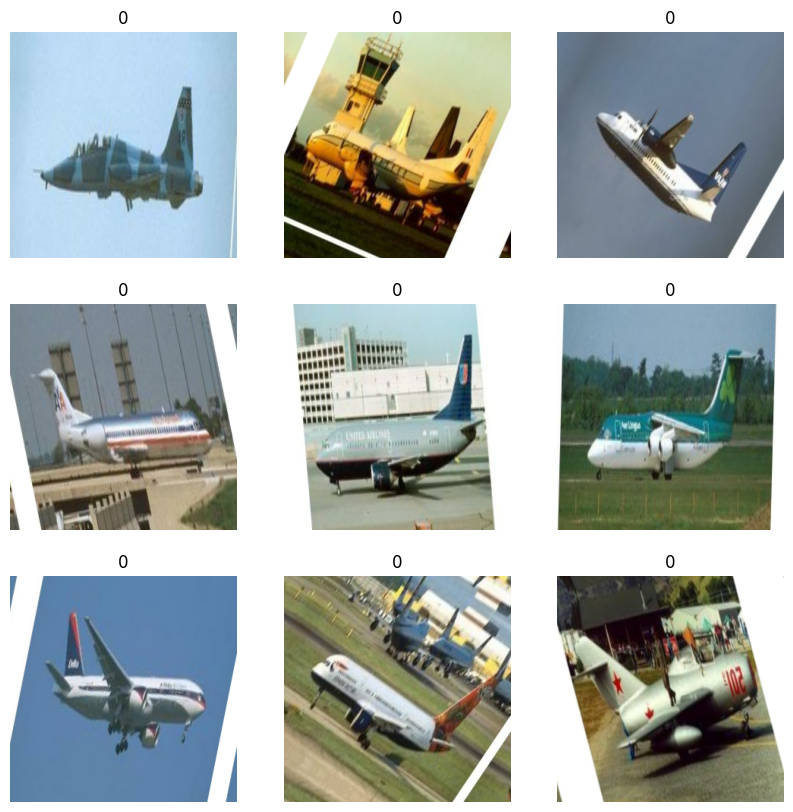

In [66]:
plt.figure(figsize=(10, 10))
# берем один батч
for images, labels in train_ds.take(1):
    # отрисуем 9 картинок из батча
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        # выводим картинку
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        # выключаем оси (чтобы они не отображались)
        plt.axis("off")

In [67]:
inc = tf.keras.applications.InceptionV3(weights='imagenet', include_top=True)
#inc.summary()

96112376/96112376 [==============================] - 830s 9us/step


In [68]:
# сохраним ссылку на входной слой сети
inp = inc.input

# создадим новый слой классификации по нашему количеству классов
new_classification_layer = tf.keras.layers.Dense(3, activation='softmax')

# соединим предпоследний слой и наш новый слой классификации
out = new_classification_layer(inc.layers[-2].output)

# создадим новую модель
model_new2 = tf.keras.Model(inp, out)

In [70]:
for layer in model_new2.layers:
    layer.trainable = False
model_new2.layers[-1].trainable = True
model_new2.layers[-2].trainable = True

In [71]:
model_new2.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_new2.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 299, 299, 3)]        0         []                            
                                                                                                  
 conv2d_3 (Conv2D)           (None, 149, 149, 32)         864       ['input_4[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 149, 149, 32)         96        ['conv2d_3[0][0]']            
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 149, 149, 32)         0         ['batch_normalization[0]

In [72]:
model_new2.fit(train_ds, epochs=12, validation_data=test_ds)

Epoch 1/12
37/37 [==============================] - 24s 583ms/step - loss: 5.7992 - accuracy: 0.7197 - val_loss: 2.2064 - val_accuracy: 0.8457
Epoch 2/12
37/37 [==============================] - 20s 551ms/step - loss: 1.2476 - accuracy: 0.8506 - val_loss: 1.3624 - val_accuracy: 0.8272
Epoch 3/12
37/37 [==============================] - 21s 553ms/step - loss: 0.7599 - accuracy: 0.8680 - val_loss: 1.3747 - val_accuracy: 0.8580
Epoch 4/12
37/37 [==============================] - 21s 553ms/step - loss: 0.5760 - accuracy: 0.8896 - val_loss: 0.8642 - val_accuracy: 0.8395
Epoch 5/12
37/37 [==============================] - 21s 552ms/step - loss: 0.6073 - accuracy: 0.9026 - val_loss: 1.0709 - val_accuracy: 0.8704
Epoch 6/12
37/37 [==============================] - 21s 552ms/step - loss: 0.4234 - accuracy: 0.9080 - val_loss: 0.7428 - val_accuracy: 0.8951
Epoch 7/12
37/37 [==============================] - 20s 548ms/step - loss: 0.4162 - accuracy: 0.9264 - val_loss: 0.6632 - val_accuracy: 0.8580

In [73]:
y_test = np.empty(25)
for images, labels in test_ds.take(1):
    for i in range(25):
        y_test[i] = int(labels[i])

In [74]:
predictions = [np.argmax(pred) for pred in model_new2.predict(test_ds)]

7/7 [==============================] - 4s 400ms/step


In [75]:
print(classification_report(y_test, predictions[:25]))
print(confusion_matrix(y_test, predictions[:25]))

              precision    recall  f1-score   support

         0.0       1.00      0.89      0.94        19
         1.0       1.00      0.75      0.86         4
         2.0       0.40      1.00      0.57         2

    accuracy                           0.88        25
   macro avg       0.80      0.88      0.79        25
weighted avg       0.95      0.88      0.90        25

[[17  0  2]
 [ 0  3  1]
 [ 0  0  2]]
